# Анализ активности пользователей Яндекс Книги: сравнение времени использования приложения в Москве и Санкт-Петербурге

- Автор: Лаптева Диана
- Дата: 15.03.2025

### Заказчик
<font color='#777778'> Команда сервиса Яндекс Книги. </font>

## Цели и задачи проекта

<font color='#777778'>
    
**Цель проекта** - изучить активность пользователей сервиса Яндекс КНиги, выявить закономерности потребления контента, проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят больше времени в приложении по сравнению с пользователями из Москвы.

**Задачи проекта**:
- Провести предобработку данных.
- Проверить гипотезу
- Подготовить аналитическую записку с описанием.</font>

## Описание данных


<font color='#777778'>

Таблица `bookmate.audition` содержит данные об активности пользователей и состоит из следующих полей:

- `audition_id` — уникальный идентификатор сессии чтения или прослушивания;
- `puid` — идентификатор пользователя;
- `usage_platform_ru` — название платформы, с помощью которой пользователь слушал контент;
- `msk_business_dt_str` — дата события в формате строки (московское время);
- `app_version` — версия приложения, которая использовалась для чтения или прослушивания;
- `adult_content_flg` — был ли это контент для взрослых: True или False;
- `hours` — длительность чтения или прослушивания в часах;
- `hours_sessions_long` — продолжительность длинных сессий чтения или прослушивания в часах;
- `kids_content_flg` — был ли это детский контент: True или False;
- `main_content_id` — идентификатор основного контента;
- `usage_geo_id` — идентификатор географического местоположения.
    
Таблица `bookmate.content` содержит данные о контенте и состоит из следующих полей:
    
- `main_content_id` — идентификатор основного контента;
- `main_author_id` — идентификатор основного автора контента;
- `main_content_type` — тип контента;
- `main_content_name`— название контента;
- `main_content_duration_hours` — длительность контента в часах;
- `published_topic_title_list` — список жанров контента.
    
Таблица `bookmate.author` содержит данные об авторах контента и состоит из следующих полей:
    
- `main_author_id` — идентификатор основного автора контента;
- `main_author_name` — имя основного автора контента.
    
Таблица `bookmate.geo` содержит данные о местоположении и состоит из следующих полей:
    
- `usage_geo_id` — идентификатор географического положения;
- `usage_geo_id_name` — город или регион географического положения;
- `usage_country_name` — страна географического положения.
</font>

## Содержимое проекта

<font color='#777778'>

1.   [Загрузка данных и знакомство с ними.](#1-bullet)
2.   [Проверка гипотезы в Python.](#2-bullet)
3.   [Аналитическая записка](#3-bullet)

</font>

---

<a class="anchor" id="1-bullet"></a>
## 1. Загрузка данных и знакомство с ними

Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью  из файла `/datasets/yandex_knigi_data.csv`. И изучим имеющиеся данные.

In [32]:
# Импорт библиотек

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

In [33]:
# Выгрузим датафрейм
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [34]:
# Выведем первые 5 строк
sessions_history.head(5)

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [35]:
# Удалим ненужный столбец
sessions_history.drop(columns=['Unnamed: 0'])

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434
...,...,...,...
8779,Санкт-Петербург,1130000028554332,4.107774
8780,Санкт-Петербург,1130000030307246,45.069222
8781,Санкт-Петербург,1130000038726322,0.211944
8782,Санкт-Петербург,1130000047892100,4.311841


In [36]:
# Проверка на дубликаты
duplicates = sessions_history.duplicated(subset=['puid']).sum()
print(duplicates)

244


In [37]:
# Удаление дубликатов по идентификаторам пользователей (puid)
sessions_history = sessions_history.drop_duplicates(subset=['puid'])

In [38]:
# Количество уникальных пользователей в каждом городе

users_per_city = sessions_history.groupby('city')['puid'].nunique()

print(f"Количество уникальных пользователей в Москве: {users_per_city['Москва']}")
print(f"Количество уникальных пользователей в Санкт-Петербурге: {users_per_city['Санкт-Петербург']}")

Количество уникальных пользователей в Москве: 6234
Количество уникальных пользователей в Санкт-Петербурге: 2306


In [39]:
# Описательные статистики по группам
print("Описательные статистики для Москвы:")
print(sessions_history[sessions_history['city'] == 'Москва']['hours'].describe())
print("\nОписательные статистики для Санкт-Петербурга:")
print(sessions_history[sessions_history['city'] == 'Санкт-Петербург']['hours'].describe())

Описательные статистики для Москвы:
count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64

Описательные статистики для Санкт-Петербурга:
count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64


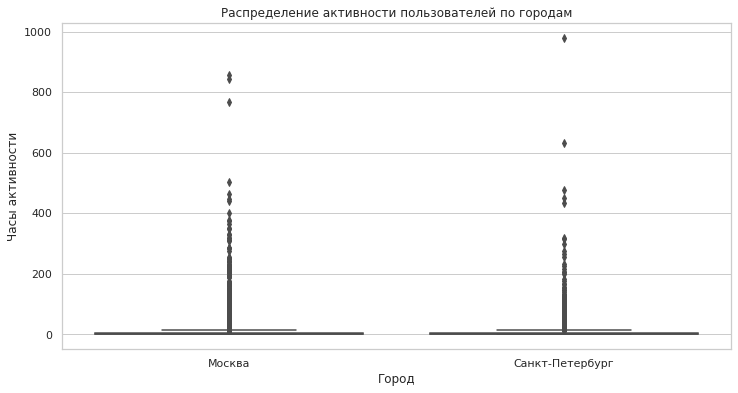

In [40]:
# Визуализация распределения активности
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='hours', data=sessions_history)
plt.title('Распределение активности пользователей по городам')
plt.xlabel('Город')
plt.ylabel('Часы активности')
plt.show()

**Вывод:**

- Пользователи из Санкт-Петербурга в среднем проводят в приложении 11.26 часов, что немного больше, чем у пользователей из Москвы (10.88 часов).
- Большинство пользователей в обоих городах проводят в приложении менее 1 часа.
- В обеих группах наблюдается высокий разброс данных.
- По графику видно, что в обеих группах присутствуют выбросы.
- В Санкт-Петербурге наблюдается большее количество выбросов.

<a class="anchor" id="2-bullet"></a>
## 2. Проверка гипотезы в Python

Формулировка гипотезы: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. 

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Уровень значимости: $\alpha = 0.05$ 

In [42]:
# Распределим на группы
moscow_data = sessions_history[sessions_history['city'] == 'Москва']['hours']
spb_data = sessions_history[sessions_history['city'] == 'Санкт-Петербург']['hours']

In [43]:
# Проверка равенства дисперсий 
levene_test = st.levene(moscow_data, spb_data)
print(f"Результат теста Левена (p-value): {levene_test.pvalue}")

if levene_test.pvalue < 0.05:
    equal_var = False  
    print("Дисперсии различаются.")
else:
    equal_var = True 
    print("Дисперсии не различаются.")

Результат теста Левена (p-value): 0.6679185085534312
Дисперсии не различаются.


In [44]:
# Вспомогательная функция для интерпретации результатов

def print_stattest_results(p_value:float, alpha:float = 0.05):
    if p_value < alpha:
        print(f"Полученное значение p_value={p_value} меньше критического уровня alpha={alpha}. Отклоняем нулевую гипотезу.")
    else:
        print(f"Полученное значение p_value={p_value} больше критического уровня alpha={alpha}. Опровергнуть нулевую гипотезу нельзя.")


t_stat, p_value = st.ttest_ind(spb_data, 
                               moscow_data, 
                               alternative='greater',
                               equal_var = True,
                               nan_policy='omit')


# Вывод результатов
print_stattest_results(p_value)
print(f"t-статистика: {t_stat}")
print(f"p-value: {p_value}")

Полученное значение p_value=0.338193679651558 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.
t-статистика: 0.4174122942907679
p-value: 0.338193679651558


**Вывод:**
Нулевую гипотезу отвергнуть мы не можем. Средняя активность пользователей в Санкт-Петербурге не превышает активность пользователей в Москве.

<a class="anchor" id="3-bullet"></a>
## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



- Целью исследования было проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят больше времени за чтением и прослушиванием книг в приложении Яндекс Книги, чем пользователи из Москвы. В качестве данных использована информация о сессиях пользователей Яндекс Книги в Москве и Санкт-Петербурге.

- Для проверки гипотезы был использован односторонний t-тест, которые позваляет сравнивать средние значения двух выборок. Был выбран уровень значимости: $\alpha = 0.05$ .

- После проведения t-теста мы получили, что значение p-value = 0.338. На основе этого значения мы не можем отклонить нулевую гипотезу. Тем самым различия в средней активности между пользователями из Санкт-Петербурга и Москвы не являются статистически значимыми.

- Причиной такого результата могли послужить следующие факторы: незначительная разница в средних значениях, наличие выбросов, размер выборки: в Москве почти в 3 раза больше пользователей, чем в Санкт-Петербурге.

- Для более точных результатов стоит провести дополнительный анализ, разделив пользователей по иным характеристикам, провести анализ пользователей с высокой активностью.